# NAO dependency

This notebook checks how the following variables are related to the NAOi for each season:
1. x-wind
2. y-wind
3. SST
4. Longwave radiation
5. Shortwave radiation
6. Precipitation (solid and liquid)
7. Runoff

In [1]:
import numpy as np
import xarray as xr
import xesmf as xe
from eofs.xarray import Eof
from eofs.examples import example_data_path
import xgcm
from sklearn import preprocessing
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy import stats

import matplotlib.pyplot as plt
import cartopy.feature as cft
import cartopy.crs as ccrs
import cmocean as cm

import cosima_cookbook as cc

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = UserWarning)
warnings.simplefilter('ignore')

--------------------------------------------------------------------------
but there are no active ports detected (or Open MPI was unable to use
them).  This is most certainly not what you wanted.  Check your
cables, subnet manager configuration, etc.  The openib BTL will be
ignored for this job.

  Local host: gadi-cpu-bdw-0622
--------------------------------------------------------------------------


In [2]:
#import dask
#from dask.distributed import Client
#client = Client()
#client

## Calculate the NAOi for each season

In [3]:
db = '/scratch/x77/db6174/mom6/archive/databases/cc_database_IAF_control.db'
session = cc.database.create_session(db)
expt = 'mom6-om4-025-IAF'

In [4]:
## 1. Start and end times
start_year, end_year = '1958', '1994'
start_time, end_time = '1958-01-01', '1994-12-31'

## 2. North Atlantic ocean coordinates
x_min, x_max = -100, 10
y_min, y_max = 10, 75

## 3. Constants
m3_to_Sv = 1e6
ρ0 = 1036
neofs = 3
neigs = 3
npcs = 3
r0 = 6.371 * 10**6

## 4. Plotting land boundaries
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black', facecolor='papayawhip', linewidth=0.5)

In [5]:
model_out = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc')

def regridder(da_in, label):
    if(label == 'ocean'):
        return regridder_ocean_to_ocean(da_in)
    elif(label == 'atmos'):
        return regridder_atmos_to_ocean(da_in)
    else:
        print('Error: Select between ocean and atmos grids.')
        
def regridder_atmos_to_ocean(da_in):
    grid_in = {'lon': da_in.lon.values, 'lat': da_in.lat.values}
    grid_out = {'lon': model_out.xt_ocean.values, 'lat': model_out.yt_ocean.values}
    
    ## Keep periodic = True, otherwise you get erroneous values at 0 longitude. 
    ## See https://github.com/JiaweiZhuang/xESMF/issues/101 for more details.
    RG = xe.Regridder(grid_in, grid_out, 'bilinear', periodic = True)
    regridded_da = RG(da_in)
    
    regridded_da = regridded_da.rename({"lon": "xt_ocean", "lat": "yt_ocean"})
    regridded_da = regridded_da.assign_coords({"geolon_t": model_out.geolon_t, "geolat_t": model_out.geolat_t})

    return regridded_da

def regridder_ocean_to_ocean(da_in):
    grid_in = {'lon': da_in.longitude.values, 'lat': da_in.latitude.values}
    grid_out = {'lon': model_out.geolon_t.values, 'lat': model_out.geolat_t.values}
    
    ## Keep periodic = True, otherwise you get erroneous values at 0 longitude. 
    ## See https://github.com/JiaweiZhuang/xESMF/issues/101 for more details.
    RG = xe.Regridder(grid_in, grid_out, 'bilinear', periodic = True)
    regridded_da = RG(da_in)

    regridded_da = regridded_da.rename({"y": "yt_ocean", "x": "xt_ocean"})
    regridded_da = regridded_da.assign_coords({"xt_ocean": model_out.xt_ocean, "yt_ocean": model_out.yt_ocean})
    regridded_da = regridded_da.rename({"lon": "geolon_t", "lat": "geolat_t"})

    return regridded_da

In [16]:
psl_all_seasons = xr.open_dataset('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/NETCDF/SLP_allseasons.nc').sel(time = slice(start_time, end_time))
psl_all_seasons = regridder(psl_all_seasons, 'atmos')

In [17]:
psl_DJF = psl_all_seasons.where(psl_all_seasons.time.dt.month.isin([12, 1, 2]), drop = True).SLP
psl_NA_DJF = psl_DJF.sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max))
psl_MAM = psl_all_seasons.where(psl_all_seasons.time.dt.month.isin([3, 4, 5]), drop = True).SLP
psl_NA_MAM = psl_MAM.sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max))
psl_JJA = psl_all_seasons.where(psl_all_seasons.time.dt.month.isin([6, 7, 8]), drop = True).SLP
psl_NA_JJA = psl_JJA.sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max))
psl_SON = psl_all_seasons.where(psl_all_seasons.time.dt.month.isin([9, 10, 11]), drop = True).SLP
psl_NA_SON = psl_SON.sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max))

In [18]:
psl_NA_DJF_mean = psl_NA_DJF.mean('time')
psl_NA_DJF_amly = psl_NA_DJF - psl_NA_DJF_mean

psl_NA_MAM_mean = psl_NA_MAM.mean('time')
psl_NA_MAM_amly = psl_NA_MAM - psl_NA_MAM_mean

psl_NA_JJA_mean = psl_NA_JJA.mean('time')
psl_NA_JJA_amly = psl_NA_JJA - psl_NA_JJA_mean

psl_NA_SON_mean = psl_NA_SON.mean('time')
psl_NA_SON_amly = psl_NA_SON - psl_NA_SON_mean

In [19]:
coslat = np.cos(np.deg2rad(psl_NA_DJF.yt_ocean.values))
wgts = np.sqrt(coslat)[..., np.newaxis]

In [20]:
solver_DJF_psl = Eof(psl_NA_DJF_amly.drop(['geolon_t', 'geolat_t']), weights = wgts)
eof_DJF_psl = solver_DJF_psl.eofsAsCovariance(neofs = neofs)

solver_MAM_psl = Eof(psl_NA_MAM_amly.drop(['geolon_t', 'geolat_t']), weights = wgts)
eof_MAM_psl = solver_MAM_psl.eofsAsCovariance(neofs = neofs)

solver_JJA_psl = Eof(psl_NA_JJA_amly.drop(['geolon_t', 'geolat_t']), weights = wgts)
eof_JJA_psl = solver_JJA_psl.eofsAsCovariance(neofs = neofs)

solver_SON_psl = Eof(psl_NA_SON_amly.drop(['geolon_t', 'geolat_t']), weights = wgts)
eof_SON_psl = solver_SON_psl.eofsAsCovariance(neofs = neofs)

In [53]:
pcs_DJF_psl = solver_DJF_psl.pcs(npcs = npcs, pcscaling = 1) * -1
pcs_MAM_psl = solver_MAM_psl.pcs(npcs = npcs, pcscaling = 1) * -1
pcs_JJA_psl = solver_JJA_psl.pcs(npcs = npcs, pcscaling = 1) * -1
pcs_SON_psl = solver_SON_psl.pcs(npcs = npcs, pcscaling = 1)* -1

## 1. x-wind stress

In [22]:
tauu = cc.querying.getvar(expt, 'tauuo', session, start_time = start_time, end_time = end_time, frequency = '1 monthly', 
                           use_cftime = True).sel(time = slice(start_time, end_time))

tauu_DJF = tauu.where(tauu.time.dt.month.isin([12, 1, 2]), drop = True)
tauu_NA_DJF = tauu_DJF.sel(xq = slice(x_min, x_max)).sel(yh = slice(y_min, y_max))
tauu_MAM = tauu.where(tauu.time.dt.month.isin([3, 4, 5]), drop = True)
tauu_NA_MAM = tauu_MAM.sel(xq = slice(x_min, x_max)).sel(yh = slice(y_min, y_max))
tauu_JJA = tauu.where(tauu.time.dt.month.isin([6, 7, 8]), drop = True)
tauu_NA_JJA = tauu_JJA.sel(xq = slice(x_min, x_max)).sel(yh = slice(y_min, y_max))
tauu_SON = tauu.where(tauu.time.dt.month.isin([9, 10, 11]), drop = True)
tauu_NA_SON = tauu_SON.sel(xq = slice(x_min, x_max)).sel(yh = slice(y_min, y_max))

In [65]:
ocean_static = xr.open_dataset('/scratch/x77/db6174/mom6/archive/mom6-om4-025-IAF/output000/19580101.ocean_static.nc')
yh = ocean_static.yh.sel(yh = slice(y_min, y_max))
yq = ocean_static.yq.sel(yq = slice(y_min, y_max))
xq = ocean_static.xq.sel(xq = slice(x_min, x_max))
xh = ocean_static.xh.sel(xh = slice(x_min, x_max))

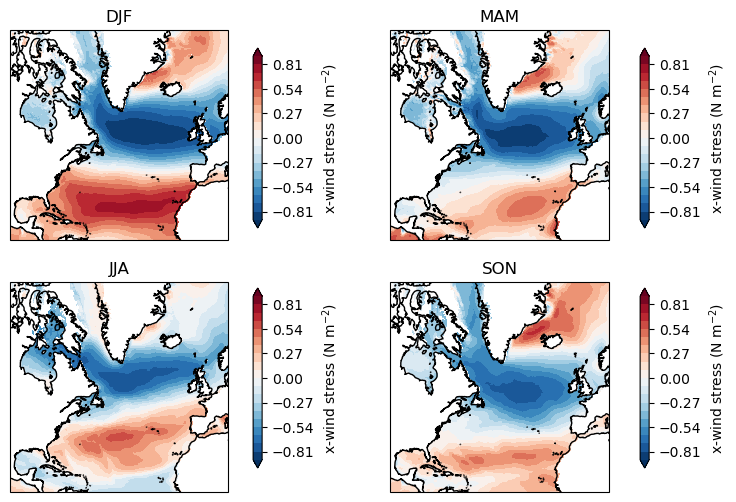

In [54]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (9, 6), subplot_kw = {'projection': projection})

label_season = ['DJF', 'MAM', 'JJA', 'SON']

a = pcs_DJF_psl.sel(mode = 0)
a['time'] = tauu_NA_DJF.time
z = xr.corr(a, tauu_NA_DJF, 'time')
p1 = axes[0][0].contourf(xq, yh, z, levels = np.linspace(-0.9, 0.9, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

a = pcs_MAM_psl.sel(mode = 0)
a['time'] = tauu_NA_MAM.time
z = xr.corr(a, tauu_NA_MAM, 'time')
p2 = axes[0][1].contourf(xq, yh, z, levels = np.linspace(-0.9, 0.9, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

a = pcs_JJA_psl.sel(mode = 0)
a['time'] = tauu_NA_JJA.time
z = xr.corr(a, tauu_NA_JJA, 'time')
p3 = axes[1][0].contourf(xq, yh, z, levels = np.linspace(-0.9, 0.9, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

a = pcs_SON_psl.sel(mode = 0)
a['time'] = tauu_NA_SON.time
z = xr.corr(a, tauu_NA_SON, 'time')
p4 = axes[1][1].contourf(xq, yh, z, levels = np.linspace(-0.9, 0.9, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

cax = plt.axes([0.45, 0.55, 0.01, 0.3])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)

cax = plt.axes([0.88, 0.55, 0.01, 0.3])
cb = plt.colorbar(p2, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)

cax = plt.axes([0.45, 0.15, 0.01, 0.3])
cb = plt.colorbar(p3, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)

cax = plt.axes([0.88, 0.15, 0.01, 0.3])
cb = plt.colorbar(p4, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)

for i in range(2):
    for j in range(2):
        axes[i][j].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
        axes[i][j].coastlines(resolution = '50m')
        axes[i][j].set_title(label_season[i*2+j])

#plt.savefig('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/Figures/SLP_NA.pdf', bbox_inches = 'tight', 
#            dpi = 300, transparent=True)

## 2. y-wind stress

In [62]:
tauv = cc.querying.getvar(expt, 'tauvo', session, start_time = start_time, end_time = end_time, frequency = '1 monthly', 
                           use_cftime = True).sel(time = slice(start_time, end_time))

tauv_DJF = tauv.where(tauv.time.dt.month.isin([12, 1, 2]), drop = True)
tauv_NA_DJF = tauv_DJF.sel(xh = slice(x_min, x_max)).sel(yq = slice(y_min, y_max))
tauv_MAM = tauv.where(tauv.time.dt.month.isin([3, 4, 5]), drop = True)
tauv_NA_MAM = tauv_MAM.sel(xh = slice(x_min, x_max)).sel(yq = slice(y_min, y_max))
tauv_JJA = tauv.where(tauv.time.dt.month.isin([6, 7, 8]), drop = True)
tauv_NA_JJA = tauv_JJA.sel(xh = slice(x_min, x_max)).sel(yq = slice(y_min, y_max))
tauv_SON = tauv.where(tauv.time.dt.month.isin([9, 10, 11]), drop = True)
tauv_NA_SON = tauv_SON.sel(xh = slice(x_min, x_max)).sel(yq = slice(y_min, y_max))

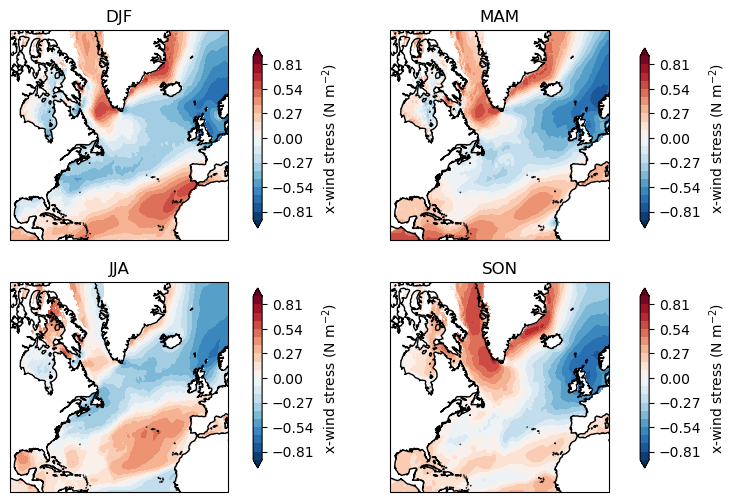

In [66]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (9, 6), subplot_kw = {'projection': projection})

label_season = ['DJF', 'MAM', 'JJA', 'SON']

a = pcs_DJF_psl.sel(mode = 0)
a['time'] = tauv_NA_DJF.time
z = xr.corr(a, tauv_NA_DJF, 'time')
p1 = axes[0][0].contourf(xh, yq, z, levels = np.linspace(-0.9, 0.9, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

a = pcs_MAM_psl.sel(mode = 0)
a['time'] = tauv_NA_MAM.time
z = xr.corr(a, tauv_NA_MAM, 'time')
p2 = axes[0][1].contourf(xh, yq, z, levels = np.linspace(-0.9, 0.9, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

a = pcs_JJA_psl.sel(mode = 0)
a['time'] = tauv_NA_JJA.time
z = xr.corr(a, tauv_NA_JJA, 'time')
p3 = axes[1][0].contourf(xh, yq, z, levels = np.linspace(-0.9, 0.9, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

a = pcs_SON_psl.sel(mode = 0)
a['time'] = tauv_NA_SON.time
z = xr.corr(a, tauv_NA_SON, 'time')
p4 = axes[1][1].contourf(xh, yq, z, levels = np.linspace(-0.9, 0.9, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

cax = plt.axes([0.45, 0.55, 0.01, 0.3])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)
#axes[0][0].set_title('DJF')

cax = plt.axes([0.88, 0.55, 0.01, 0.3])
cb = plt.colorbar(p2, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)
#axes[0][1].set_title('MAM')

cax = plt.axes([0.45, 0.15, 0.01, 0.3])
cb = plt.colorbar(p3, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)
#axes[1][0].set_title('JJA')

cax = plt.axes([0.88, 0.15, 0.01, 0.3])
cb = plt.colorbar(p4, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)
#axes[1][1].set_title('SON')

for i in range(2):
    for j in range(2):
        axes[i][j].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
        axes[i][j].coastlines(resolution = '50m')
        axes[i][j].set_title(label_season[i*2+j])

#plt.savefig('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/Figures/SLP_NA.pdf', bbox_inches = 'tight', 
#            dpi = 300, transparent=True)

## 3. SST

In [69]:
SST = cc.querying.getvar(expt, 'tos', session, start_time = start_time, end_time = end_time, frequency = '1 monthly', 
                           use_cftime = True).sel(time = slice(start_time, end_time))

SST_DJF = SST.where(SST.time.dt.month.isin([12, 1, 2]), drop = True)
SST_NA_DJF = SST_DJF.sel(xh = slice(x_min, x_max)).sel(yh = slice(y_min, y_max))
SST_MAM = SST.where(SST.time.dt.month.isin([3, 4, 5]), drop = True)
SST_NA_MAM = SST_MAM.sel(xh = slice(x_min, x_max)).sel(yh = slice(y_min, y_max))
SST_JJA = SST.where(SST.time.dt.month.isin([6, 7, 8]), drop = True)
SST_NA_JJA = SST_JJA.sel(xh = slice(x_min, x_max)).sel(yh = slice(y_min, y_max))
SST_SON = SST.where(SST.time.dt.month.isin([9, 10, 11]), drop = True)
SST_NA_SON = SST_SON.sel(xh = slice(x_min, x_max)).sel(yh = slice(y_min, y_max))

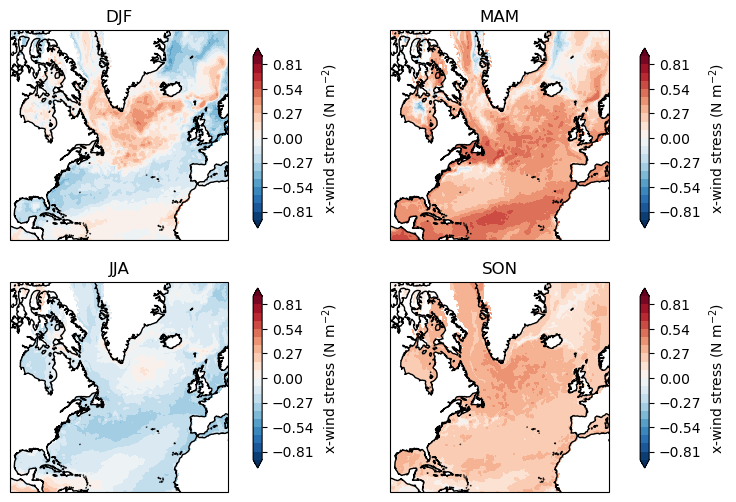

In [71]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (9, 6), subplot_kw = {'projection': projection})

label_season = ['DJF', 'MAM', 'JJA', 'SON']

a = pcs_DJF_psl.sel(mode = 0)
a['time'] = SST_NA_DJF.time
z = xr.corr(a, SST_NA_DJF, 'time')
p1 = axes[0][0].contourf(xh, yh, z, levels = np.linspace(-0.9, 0.9, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

a = pcs_MAM_psl.sel(mode = 0)
a['time'] = SST_NA_MAM.time
z = xr.corr(a, SST_NA_MAM, 'time')
p2 = axes[0][1].contourf(xh, yh, z, levels = np.linspace(-0.9, 0.9, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

a = pcs_JJA_psl.sel(mode = 0)
a['time'] = SST_NA_JJA.time
z = xr.corr(a, SST_NA_JJA, 'time')
p3 = axes[1][0].contourf(xh, yh, z, levels = np.linspace(-0.9, 0.9, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

a = pcs_SON_psl.sel(mode = 0)
a['time'] = SST_NA_SON.time
z = xr.corr(a, SST_NA_SON, 'time')
p4 = axes[1][1].contourf(xh, yh, z, levels = np.linspace(-0.9, 0.9, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

cax = plt.axes([0.45, 0.55, 0.01, 0.3])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)

cax = plt.axes([0.88, 0.55, 0.01, 0.3])
cb = plt.colorbar(p2, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)

cax = plt.axes([0.45, 0.15, 0.01, 0.3])
cb = plt.colorbar(p3, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)

cax = plt.axes([0.88, 0.15, 0.01, 0.3])
cb = plt.colorbar(p4, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)

for i in range(2):
    for j in range(2):
        axes[i][j].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
        axes[i][j].coastlines(resolution = '50m')
        axes[i][j].set_title(label_season[i*2+j])

#plt.savefig('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/Figures/SLP_NA.pdf', bbox_inches = 'tight', 
#            dpi = 300, transparent=True)

## Longwave radiation

In [73]:
rlntds = cc.querying.getvar(expt, 'rlntds', session, start_time = start_time, end_time = end_time, frequency = '1 monthly', 
                           use_cftime = True).sel(time = slice(start_time, end_time))

rlntds_DJF = rlntds.where(rlntds.time.dt.month.isin([12, 1, 2]), drop = True)
rlntds_NA_DJF = rlntds_DJF.sel(xh = slice(x_min, x_max)).sel(yh = slice(y_min, y_max))
rlntds_MAM = rlntds.where(rlntds.time.dt.month.isin([3, 4, 5]), drop = True)
rlntds_NA_MAM = rlntds_MAM.sel(xh = slice(x_min, x_max)).sel(yh = slice(y_min, y_max))
rlntds_JJA = rlntds.where(rlntds.time.dt.month.isin([6, 7, 8]), drop = True)
rlntds_NA_JJA = rlntds_JJA.sel(xh = slice(x_min, x_max)).sel(yh = slice(y_min, y_max))
rlntds_SON = rlntds.where(rlntds.time.dt.month.isin([9, 10, 11]), drop = True)
rlntds_NA_SON = rlntds_SON.sel(xh = slice(x_min, x_max)).sel(yh = slice(y_min, y_max))

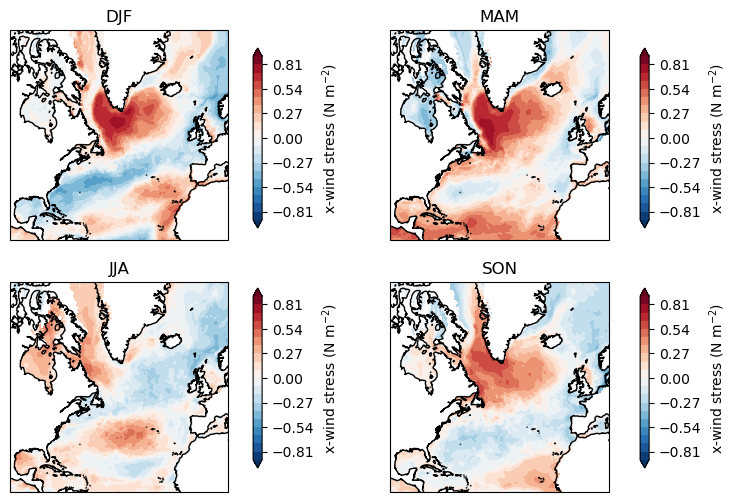

In [75]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (9, 6), subplot_kw = {'projection': projection})

label_season = ['DJF', 'MAM', 'JJA', 'SON']

a = pcs_DJF_psl.sel(mode = 0)
a['time'] = rlntds_NA_DJF.time
z = xr.corr(a, rlntds_NA_DJF, 'time')
p1 = axes[0][0].contourf(xh, yh, z, levels = np.linspace(-0.9, 0.9, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

a = pcs_MAM_psl.sel(mode = 0)
a['time'] = rlntds_NA_MAM.time
z = xr.corr(a, rlntds_NA_MAM, 'time')
p2 = axes[0][1].contourf(xh, yh, z, levels = np.linspace(-0.9, 0.9, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

a = pcs_JJA_psl.sel(mode = 0)
a['time'] = rlntds_NA_JJA.time
z = xr.corr(a, rlntds_NA_JJA, 'time')
p3 = axes[1][0].contourf(xh, yh, z, levels = np.linspace(-0.9, 0.9, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

a = pcs_SON_psl.sel(mode = 0)
a['time'] = rlntds_NA_SON.time
z = xr.corr(a, rlntds_NA_SON, 'time')
p4 = axes[1][1].contourf(xh, yh, z, levels = np.linspace(-0.9, 0.9, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

cax = plt.axes([0.45, 0.55, 0.01, 0.3])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)

cax = plt.axes([0.88, 0.55, 0.01, 0.3])
cb = plt.colorbar(p2, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)

cax = plt.axes([0.45, 0.15, 0.01, 0.3])
cb = plt.colorbar(p3, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)

cax = plt.axes([0.88, 0.15, 0.01, 0.3])
cb = plt.colorbar(p4, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)

for i in range(2):
    for j in range(2):
        axes[i][j].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
        axes[i][j].coastlines(resolution = '50m')
        axes[i][j].set_title(label_season[i*2+j])

#plt.savefig('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/Figures/SLP_NA.pdf', bbox_inches = 'tight', 
#            dpi = 300, transparent=True)

## Shortwave radiation

In [76]:
rsntds = cc.querying.getvar(expt, 'rsntds', session, start_time = start_time, end_time = end_time, frequency = '1 monthly', 
                           use_cftime = True).sel(time = slice(start_time, end_time))

rsntds_DJF = rsntds.where(rsntds.time.dt.month.isin([12, 1, 2]), drop = True)
rsntds_NA_DJF = rsntds_DJF.sel(xh = slice(x_min, x_max)).sel(yh = slice(y_min, y_max))
rsntds_MAM = rsntds.where(rsntds.time.dt.month.isin([3, 4, 5]), drop = True)
rsntds_NA_MAM = rsntds_MAM.sel(xh = slice(x_min, x_max)).sel(yh = slice(y_min, y_max))
rsntds_JJA = rsntds.where(rsntds.time.dt.month.isin([6, 7, 8]), drop = True)
rsntds_NA_JJA = rsntds_JJA.sel(xh = slice(x_min, x_max)).sel(yh = slice(y_min, y_max))
rsntds_SON = rsntds.where(rsntds.time.dt.month.isin([9, 10, 11]), drop = True)
rsntds_NA_SON = rsntds_SON.sel(xh = slice(x_min, x_max)).sel(yh = slice(y_min, y_max))

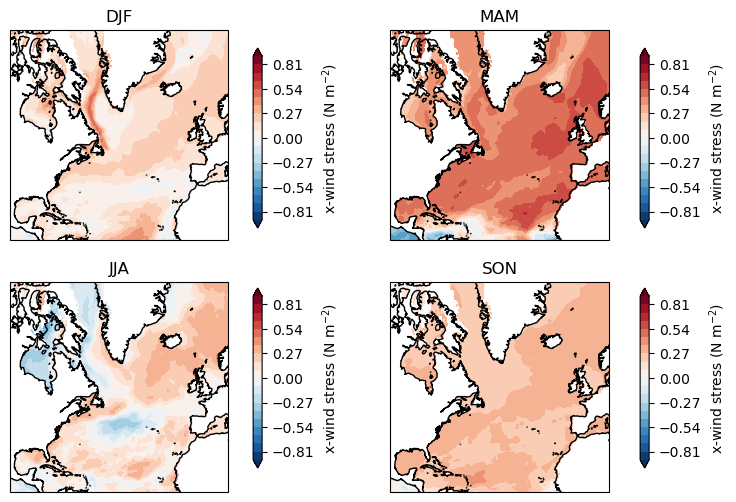

In [77]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (9, 6), subplot_kw = {'projection': projection})

label_season = ['DJF', 'MAM', 'JJA', 'SON']

a = pcs_DJF_psl.sel(mode = 0)
a['time'] = rsntds_NA_DJF.time
z = xr.corr(a, rsntds_NA_DJF, 'time')
p1 = axes[0][0].contourf(xh, yh, z, levels = np.linspace(-0.9, 0.9, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

a = pcs_MAM_psl.sel(mode = 0)
a['time'] = rsntds_NA_MAM.time
z = xr.corr(a, rsntds_NA_MAM, 'time')
p2 = axes[0][1].contourf(xh, yh, z, levels = np.linspace(-0.9, 0.9, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

a = pcs_JJA_psl.sel(mode = 0)
a['time'] = rsntds_NA_JJA.time
z = xr.corr(a, rsntds_NA_JJA, 'time')
p3 = axes[1][0].contourf(xh, yh, z, levels = np.linspace(-0.9, 0.9, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

a = pcs_SON_psl.sel(mode = 0)
a['time'] = rsntds_NA_SON.time
z = xr.corr(a, rsntds_NA_SON, 'time')
p4 = axes[1][1].contourf(xh, yh, z, levels = np.linspace(-0.9, 0.9, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

cax = plt.axes([0.45, 0.55, 0.01, 0.3])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)

cax = plt.axes([0.88, 0.55, 0.01, 0.3])
cb = plt.colorbar(p2, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)

cax = plt.axes([0.45, 0.15, 0.01, 0.3])
cb = plt.colorbar(p3, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)

cax = plt.axes([0.88, 0.15, 0.01, 0.3])
cb = plt.colorbar(p4, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)

for i in range(2):
    for j in range(2):
        axes[i][j].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
        axes[i][j].coastlines(resolution = '50m')
        axes[i][j].set_title(label_season[i*2+j])

#plt.savefig('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/Figures/SLP_NA.pdf', bbox_inches = 'tight', 
#            dpi = 300, transparent=True)

## Liquid precipitation

In [78]:
prlq = cc.querying.getvar(expt, 'prlq', session, start_time = start_time, end_time = end_time, frequency = '1 monthly', 
                           use_cftime = True).sel(time = slice(start_time, end_time))

prlq_DJF = prlq.where(prlq.time.dt.month.isin([12, 1, 2]), drop = True)
prlq_NA_DJF = prlq_DJF.sel(xh = slice(x_min, x_max)).sel(yh = slice(y_min, y_max))
prlq_MAM = prlq.where(prlq.time.dt.month.isin([3, 4, 5]), drop = True)
prlq_NA_MAM = prlq_MAM.sel(xh = slice(x_min, x_max)).sel(yh = slice(y_min, y_max))
prlq_JJA = prlq.where(prlq.time.dt.month.isin([6, 7, 8]), drop = True)
prlq_NA_JJA = prlq_JJA.sel(xh = slice(x_min, x_max)).sel(yh = slice(y_min, y_max))
prlq_SON = prlq.where(prlq.time.dt.month.isin([9, 10, 11]), drop = True)
prlq_NA_SON = prlq_SON.sel(xh = slice(x_min, x_max)).sel(yh = slice(y_min, y_max))

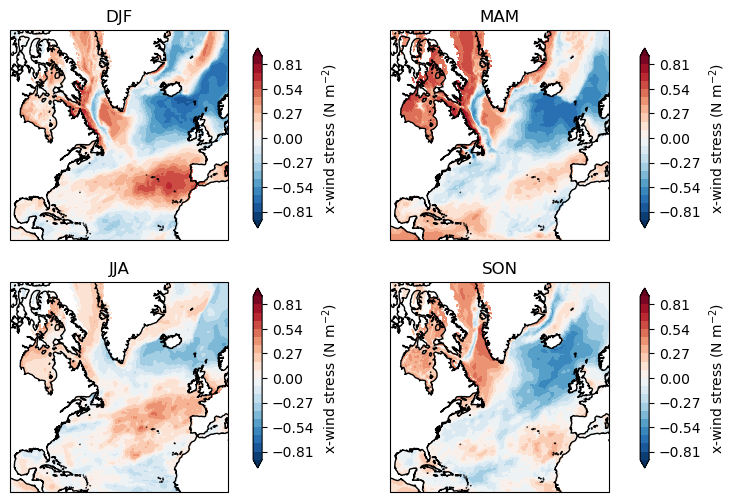

In [79]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (9, 6), subplot_kw = {'projection': projection})

label_season = ['DJF', 'MAM', 'JJA', 'SON']

a = pcs_DJF_psl.sel(mode = 0)
a['time'] = prlq_NA_DJF.time
z = xr.corr(a, prlq_NA_DJF, 'time')
p1 = axes[0][0].contourf(xh, yh, z, levels = np.linspace(-0.9, 0.9, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

a = pcs_MAM_psl.sel(mode = 0)
a['time'] = prlq_NA_MAM.time
z = xr.corr(a, prlq_NA_MAM, 'time')
p2 = axes[0][1].contourf(xh, yh, z, levels = np.linspace(-0.9, 0.9, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

a = pcs_JJA_psl.sel(mode = 0)
a['time'] = prlq_NA_JJA.time
z = xr.corr(a, prlq_NA_JJA, 'time')
p3 = axes[1][0].contourf(xh, yh, z, levels = np.linspace(-0.9, 0.9, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

a = pcs_SON_psl.sel(mode = 0)
a['time'] = prlq_NA_SON.time
z = xr.corr(a, prlq_NA_SON, 'time')
p4 = axes[1][1].contourf(xh, yh, z, levels = np.linspace(-0.9, 0.9, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

cax = plt.axes([0.45, 0.55, 0.01, 0.3])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)

cax = plt.axes([0.88, 0.55, 0.01, 0.3])
cb = plt.colorbar(p2, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)

cax = plt.axes([0.45, 0.15, 0.01, 0.3])
cb = plt.colorbar(p3, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)

cax = plt.axes([0.88, 0.15, 0.01, 0.3])
cb = plt.colorbar(p4, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)

for i in range(2):
    for j in range(2):
        axes[i][j].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
        axes[i][j].coastlines(resolution = '50m')
        axes[i][j].set_title(label_season[i*2+j])

#plt.savefig('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/Figures/SLP_NA.pdf', bbox_inches = 'tight', 
#            dpi = 300, transparent=True)

## Frozen precipitation

In [80]:
prsn = cc.querying.getvar(expt, 'prlq', session, start_time = start_time, end_time = end_time, frequency = '1 monthly', 
                           use_cftime = True).sel(time = slice(start_time, end_time))

prsn_DJF = prsn.where(prsn.time.dt.month.isin([12, 1, 2]), drop = True)
prsn_NA_DJF = prsn_DJF.sel(xh = slice(x_min, x_max)).sel(yh = slice(y_min, y_max))
prsn_MAM = prsn.where(prsn.time.dt.month.isin([3, 4, 5]), drop = True)
prsn_NA_MAM = prsn_MAM.sel(xh = slice(x_min, x_max)).sel(yh = slice(y_min, y_max))
prsn_JJA = prsn.where(prsn.time.dt.month.isin([6, 7, 8]), drop = True)
prsn_NA_JJA = prsn_JJA.sel(xh = slice(x_min, x_max)).sel(yh = slice(y_min, y_max))
prsn_SON = prsn.where(prsn.time.dt.month.isin([9, 10, 11]), drop = True)
prsn_NA_SON = prsn_SON.sel(xh = slice(x_min, x_max)).sel(yh = slice(y_min, y_max))

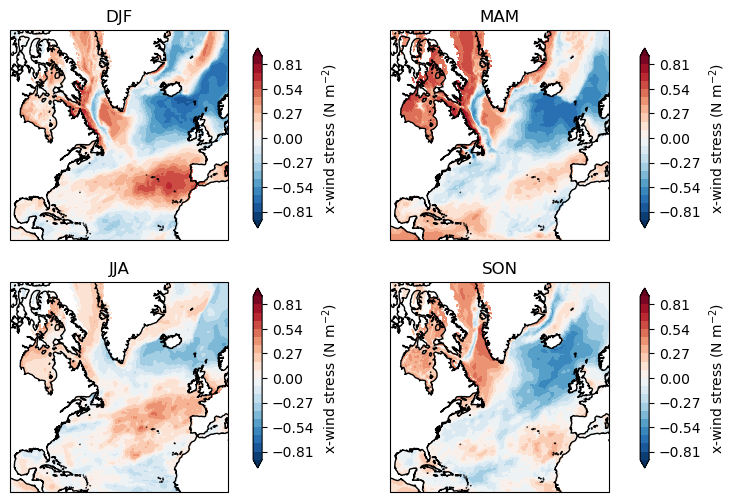

In [81]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (9, 6), subplot_kw = {'projection': projection})

label_season = ['DJF', 'MAM', 'JJA', 'SON']

a = pcs_DJF_psl.sel(mode = 0)
a['time'] = prsn_NA_DJF.time
z = xr.corr(a, prsn_NA_DJF, 'time')
p1 = axes[0][0].contourf(xh, yh, z, levels = np.linspace(-0.9, 0.9, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

a = pcs_MAM_psl.sel(mode = 0)
a['time'] = prsn_NA_MAM.time
z = xr.corr(a, prsn_NA_MAM, 'time')
p2 = axes[0][1].contourf(xh, yh, z, levels = np.linspace(-0.9, 0.9, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

a = pcs_JJA_psl.sel(mode = 0)
a['time'] = prsn_NA_JJA.time
z = xr.corr(a, prsn_NA_JJA, 'time')
p3 = axes[1][0].contourf(xh, yh, z, levels = np.linspace(-0.9, 0.9, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

a = pcs_SON_psl.sel(mode = 0)
a['time'] = prsn_NA_SON.time
z = xr.corr(a, prsn_NA_SON, 'time')
p4 = axes[1][1].contourf(xh, yh, z, levels = np.linspace(-0.9, 0.9, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

cax = plt.axes([0.45, 0.55, 0.01, 0.3])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)

cax = plt.axes([0.88, 0.55, 0.01, 0.3])
cb = plt.colorbar(p2, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)

cax = plt.axes([0.45, 0.15, 0.01, 0.3])
cb = plt.colorbar(p3, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)

cax = plt.axes([0.88, 0.15, 0.01, 0.3])
cb = plt.colorbar(p4, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)

for i in range(2):
    for j in range(2):
        axes[i][j].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
        axes[i][j].coastlines(resolution = '50m')
        axes[i][j].set_title(label_season[i*2+j])

#plt.savefig('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/Figures/SLP_NA.pdf', bbox_inches = 'tight', 
#            dpi = 300, transparent=True)